In [1]:
files=['test_identity.csv', 
         'test_transaction.csv',
         'train_identity.csv',
         'train_transaction.csv']

In [2]:
import pandas as pd
def load_data(file):
    return pd.read_csv(file,index_col='TransactionID')

In [3]:
#import multiprocessing
#import time
#with multiprocessing.Pool() as pool:
#pool=multiprocessing.Pool()
#test_id,test_trans,train_id,train_trans=load_data(files[0]),load_data(files[1]),load_data(files[2]),load_data(files[3])

import multiprocessing
import time
with multiprocessing.Pool() as pool:
    test_id,test_trans,train_id,train_trans=pool.map(load_data,files)

In [4]:
train=train_trans.merge(train_id,how='left',left_index=True,right_index=True)
test=test_trans.merge(test_id,how='left',left_index=True,right_index=True)

In [14]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,DeviceType,DeviceInfo,TransactionDT1,month,day,dayofweek,hour,weekofyear,TransactionAmt_decimal,nulls
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,2017-12-02 00:00:00,12,2,5,0,48,500,234
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,2017-12-02 00:00:01,12,2,5,0,48,0,230
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,2017-12-02 00:01:09,12,2,5,0,48,0,211
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,2017-12-02 00:01:39,12,2,5,0,48,0,227
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,mobile,SAMSUNG SM-G892A Build/NRD90M,2017-12-02 00:01:46,12,2,5,0,48,0,137


In [5]:
test_id.shape

(141907, 40)

In [6]:
test_trans.shape

(506691, 392)

In [7]:
import datetime
startDT = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
startDT

datetime.datetime(2017, 12, 1, 0, 0)

In [8]:
#add month,day of month,day of week,hour of day
train['TransactionDT1']=train['TransactionDT'].apply(lambda x:(startDT+datetime.timedelta(seconds=x)))
train['month']=train['TransactionDT1'].dt.date.apply(lambda x: int(x.strftime('%m')))
train['day']=train['TransactionDT1'].dt.date.apply(lambda x: int(x.strftime('%d')))
train['dayofweek']=train['TransactionDT1'].dt.date.apply(lambda x: x.weekday())
train['hour']=train['TransactionDT1'].apply(lambda x: int(x.strftime('%H')))
train['weekofyear']=train['TransactionDT1'].apply(lambda x: int(x.strftime('%U')))

#engineer Month to start from 12 and monotonous increasing;
#seems redcuce score...
#train['month'] = (train['TransactionDT1'].dt.year-2017)*12 + train['TransactionDT1'].dt.month 
#train.iloc[299000:299100]

In [9]:
test['TransactionDT1']=test['TransactionDT'].apply(lambda x:(startDT+datetime.timedelta(seconds=x)))
test['month']=test['TransactionDT1'].dt.date.apply(lambda x: int(x.strftime('%m')))
test['day']=test['TransactionDT1'].dt.date.apply(lambda x: int(x.strftime('%d')))
test['dayofweek']=test['TransactionDT1'].dt.date.apply(lambda x: x.weekday())
test['hour']=test['TransactionDT1'].apply(lambda x: int(x.strftime('%H')))
test['weekofyear']=test['TransactionDT1'].apply(lambda x: int(x.strftime('%U')))

#engineer Month to start from 12 and monotonous increasing;
#test['month'] = (test['TransactionDT1'].dt.year-2017)*12 + test['TransactionDT1'].dt.month 

test.head(3)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_37,id_38,DeviceType,DeviceInfo,TransactionDT1,month,day,dayofweek,hour,weekofyear
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,2018-07-02 00:00:24,7,2,0,0,26
3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,...,NaN,NaN,NaN,NaN,2018-07-02 00:01:03,7,2,0,0,26
3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,...,NaN,NaN,NaN,NaN,2018-07-02 00:01:50,7,2,0,0,26


In [10]:
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)
#plot_numerical1('TransactionAmt_decimal')

In [11]:
#creat new feature: Number of NaN's
train['nulls']=train.isnull().sum(axis=1)
test['nulls']=test.isnull().sum(axis=1)

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import suptitle


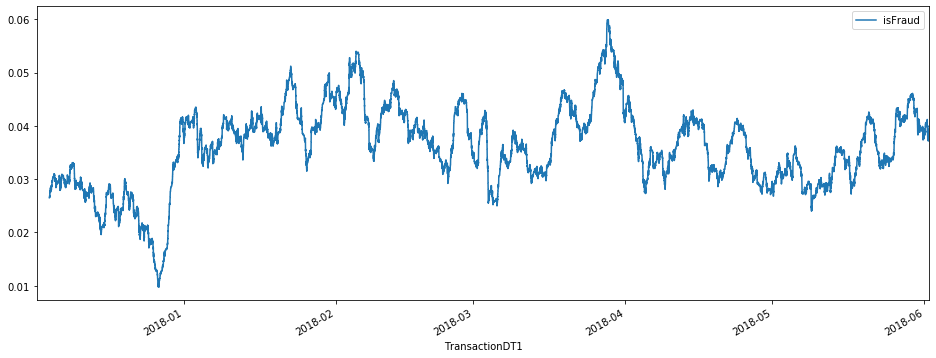

In [129]:
fig,axes=plt.subplots(1,1,figsize=(16,6))
train[['TransactionDT1', 'isFraud']].set_index('TransactionDT1').rolling(10000).mean().plot(ax=axes);

In [131]:
y = train['isFraud']
X = pd.DataFrame()
X['card1'] = train['card1']
X['card1_count'] = train['card1'].map(pd.concat([train['card1'], test['card1']], 
                                        ignore_index=True).value_counts(dropna=False))

/Users/ruiqianyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


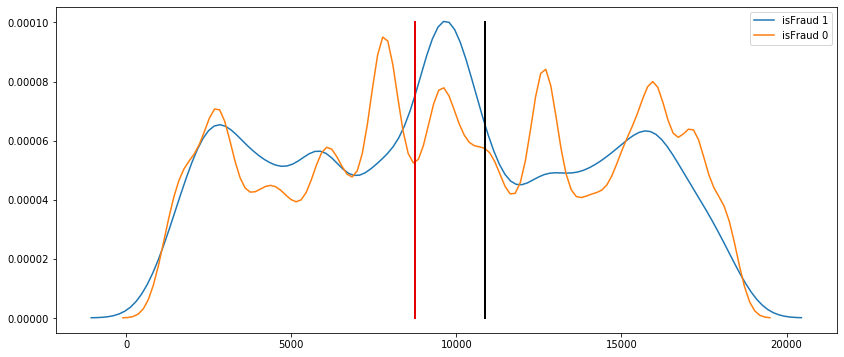

In [132]:
#Card1
plt.figure(figsize=(14, 6))
sns.kdeplot(X[y==1]['card1'], label='isFraud 1');
sns.kdeplot(X[y==0]['card1'], label='isFraud 0');
plt.plot([10881.5, 10881.5], [0.0000, 0.0001], sns.xkcd_rgb["black"], lw=2);
plt.plot([8750.0, 8750.0], [0.0000, 0.0001], sns.xkcd_rgb["red"], lw=2);

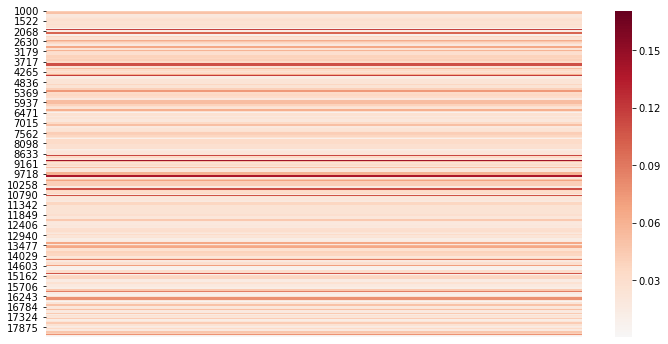

In [134]:
#boosting model on only one original feature card1
import lightgbm as lgb
params = {'objective': 'binary', "boosting_type": "gbdt", "subsample": 1, "bagging_seed": 11, "metric": 'auc', 'random_state': 47}
X_train, X_test, y_train, y_test = train_test_split(X['card1'], y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train.values.reshape(-1, 1), y_train)
roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1])
#let's create a heatmap with a probability of isFraud=1 for every unique value in the card1 feature
plt.figure(figsize=(12, 6))
x = clf.predict_proba(X['card1'].sort_values().unique().reshape(-1, 1))[:, 1]
x = pd.Series(x, index=X['card1'].sort_values().unique())
sns.heatmap(x.to_frame(), cmap='RdBu_r', center=0.0);
plt.xticks([]);

In [135]:
import lightgbm as lgb
params = {'objective': 'binary', "boosting_type": "gbdt", "subsample": 1, "bagging_seed": 11, "metric": 'auc', 'random_state': 47}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.7677377885485746

/Users/ruiqianyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


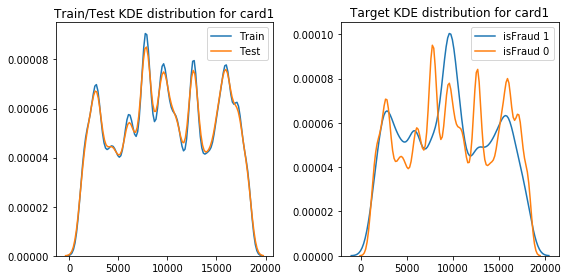

In [139]:
#plot_numerical('card1') #kernel density estimation
#card1 values distribution in Train and Test are comparable;
#isFraud distribution is different per card1



def plot_numerical(var):
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    sns.kdeplot(X_train[var], label='Train')
    sns.kdeplot(X_test[var], label='Test')
    plt.title('Train/Test KDE distribution for '+var) 
    
    plt.subplot(1,2,2)
    sns.kdeplot(X[y==1][var], label='isFraud 1')
    sns.kdeplot(X[y==0][var], label='isFraud 0')
    plt.title('Target KDE distribution for '+var)
    
    plt.tight_layout()

plot_numerical('card1');

/Users/ruiqianyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


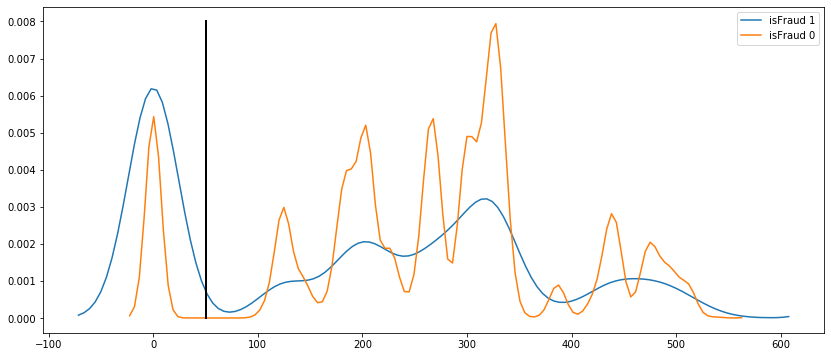

In [143]:
#Addr1
y = train['isFraud']
X = pd.DataFrame()
X['addr1'] = train['addr1']
X['addr1_count'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
X['addr1'].fillna(0, inplace=True)
plt.figure(figsize=(14, 6))
sns.kdeplot(X[y==1]['addr1'], label='isFraud 1');
sns.kdeplot(X[y==0]['addr1'], label='isFraud 0');
plt.plot([50.0, 50.0], [0.0000, 0.008], sns.xkcd_rgb["black"], lw=2);

/Users/ruiqianyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


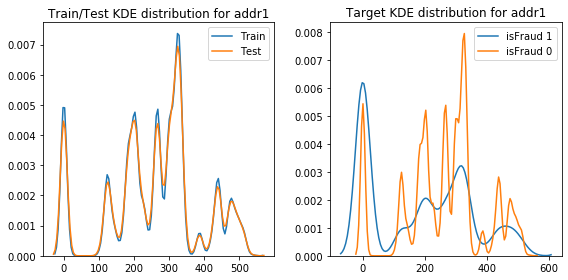

In [147]:
params = {'objective': 'binary', "boosting_type": "gbdt", "subsample": 1, "bagging_seed": 11, "metric": 'auc', 'random_state': 47}
X_train, X_test, y_train, y_test = train_test_split(X['addr1'], y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train.values.reshape(-1, 1), y_train)
roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

plot_numerical('addr1')  #kernel density estimation

/Users/ruiqianyang/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


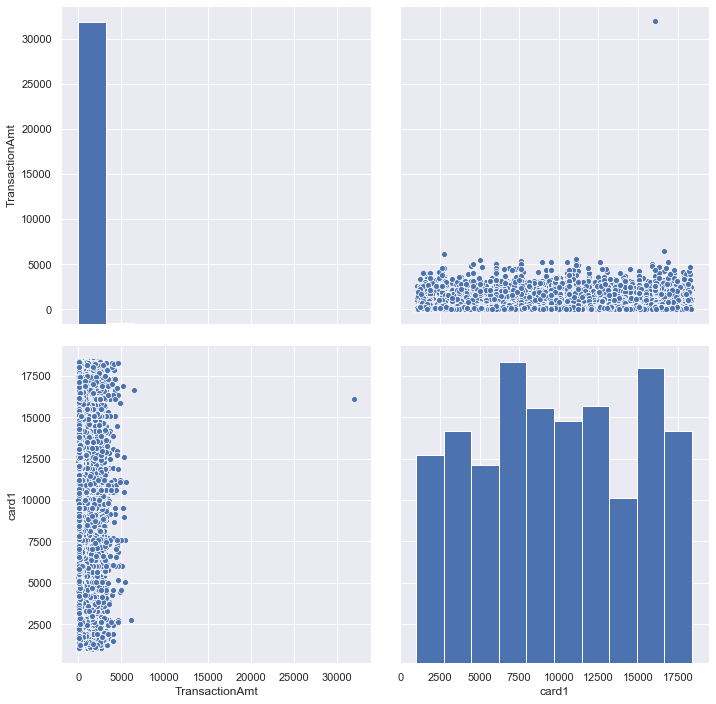

In [148]:
#scatterplot
sns.set()
cols = ['TransactionAmt','card1']
sns.pairplot(train[cols], size = 5)
plt.show();

/Users/ruiqianyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


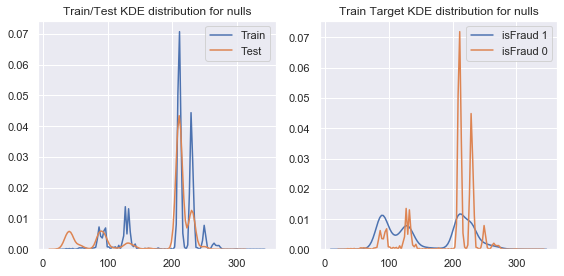

In [149]:
#scatterplot
def plot_numerical1(var):
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    sns.kdeplot(train[var], label='Train')
    sns.kdeplot(test[var], label='Test')
    plt.title('Train/Test KDE distribution for '+var) 
    
    plt.subplot(1,2,2)
    sns.kdeplot(train[y==1][var], label='isFraud 1')
    sns.kdeplot(train[y==0][var], label='isFraud 0')
    plt.title('Train Target KDE distribution for '+var)
    
    plt.tight_layout()
    
plot_numerical1('nulls')

/Users/ruiqianyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


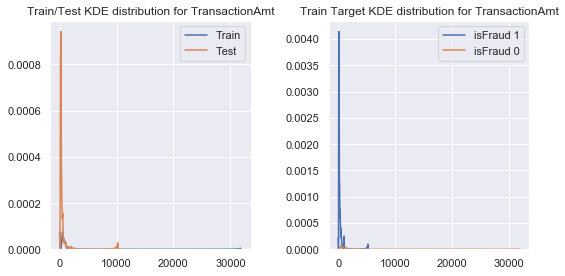

In [150]:
#TransactionAmt

plot_numerical1('TransactionAmt')

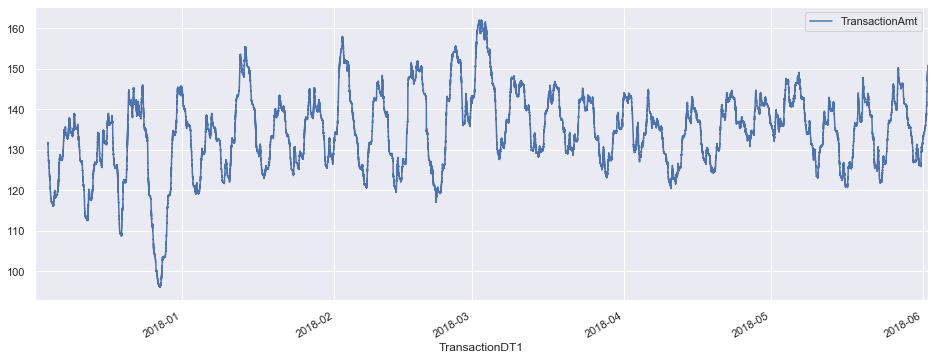

In [152]:
#Moving average for TransactionAmt over time.
fig, axes = plt.subplots(1,1,figsize=(16, 6))
train[['TransactionDT1', 'TransactionAmt'
      ]].set_index('TransactionDT1').rolling(10000).mean().plot(ax=axes);

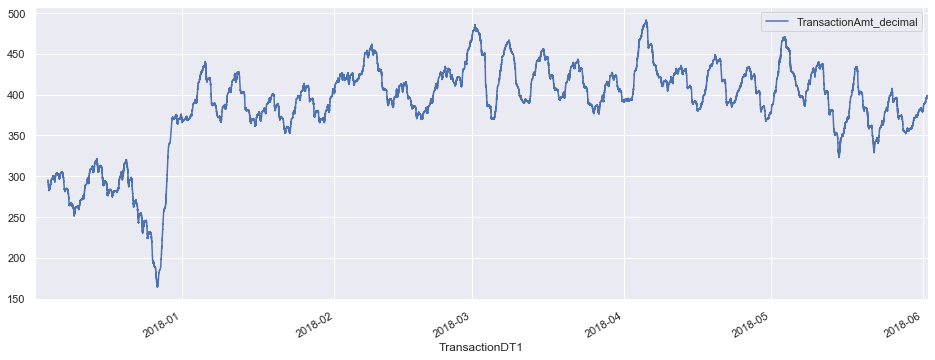

In [153]:
#Moving average for TransactionAmt over time.
fig, axes = plt.subplots(1,1,figsize=(16, 6))
train[['TransactionDT1', 'TransactionAmt_decimal']].set_index('TransactionDT1').rolling(10000).mean().plot(ax=axes);

In [16]:
#creat a small tree with V13 and TransactionDT
y = train['isFraud']
X = pd.DataFrame()
X['V13'] = train['V13']
X['V13'].fillna(X['V13'].mode()[0], inplace=True)
X['TransactionDT'] = train['TransactionDT']
#X['C2_count'] = train['C2'].map(pd.concat([train['C2'], test['C2']], ignore_index=True).value_counts(dropna=False))
#from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#from sklearn.metrics import roc_auc_score
#decision tree model with card1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = DecisionTreeClassifier(max_leaf_nodes=5)
clf.fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.5824093666099924

In [17]:
from sklearn import tree
import graphviz

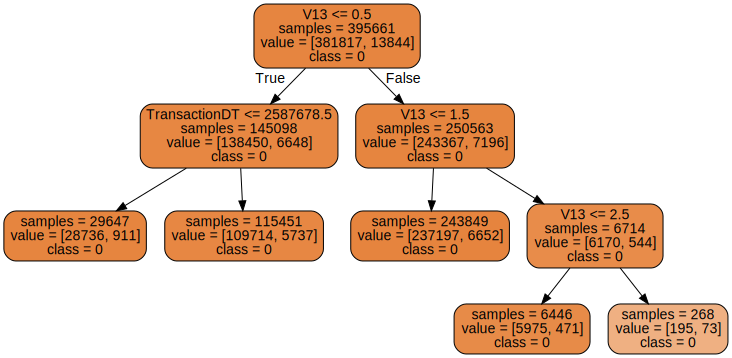

In [18]:
tree_graph = tree.export_graphviz(clf, out_file=None, max_depth = 10,
    impurity = False, feature_names = X.columns, class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)


###finish exploring

In [19]:
train.columns

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'DeviceType', 'DeviceInfo', 'TransactionDT1', 'month', 'day',
       'dayofweek', 'hour', 'weekofyear', 'TransactionAmt_decimal', 'nulls'],
      dtype='object', length=441)

In [20]:
test.columns

Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'DeviceType', 'DeviceInfo', 'TransactionDT1', 'month', 'day',
       'dayofweek', 'hour', 'weekofyear', 'TransactionAmt_decimal', 'nulls'],
      dtype='object', length=440)

In [27]:
#for explore interaction such as V13_TransactionDT features plot part
data=pd.concat((X,y),axis=1)
data['month']=train['month']
data['V13_month']=data['V13'].astype(str)+'_'+data['month'].astype(str)
data.groupby('V13_month')['isFraud'].mean().nlargest(10)

V13_month
5.0_1     1.000000
5.0_12    1.000000
5.0_2     1.000000
3.0_1     0.680000
4.0_12    0.666667
4.0_1     0.500000
4.0_2     0.500000
3.0_3     0.339623
3.0_6     0.333333
3.0_2     0.307692
Name: isFraud, dtype: float64

In [35]:
data.groupby('V13').count()

,TransactionDT,isFraud,month,V13_month
V13,,,,
0.0,216752,216752,216752,216752
1.0,363717,363717,363717,363717
2.0,9661,9661,9661,9661
3.0,371,371,371,371
4.0,26,26,26,26
5.0,10,10,10,10
6.0,3,3,3,3


In [46]:
a=data.groupby('V13_month')['isFraud'].count()
a

V13_month
0.0_1     38132
0.0_12    45568
0.0_2     37725
0.0_3     36384
0.0_4     28783
0.0_5     29365
0.0_6       795
1.0_1     52841
1.0_12    87116
1.0_2     46682
1.0_3     63665
1.0_4     53253
1.0_5     58294
1.0_6      1866
2.0_1      1478
2.0_12     1602
2.0_2      1289
2.0_3      1857
2.0_4      1463
2.0_5      1882
2.0_6        90
3.0_1        50
3.0_12       46
3.0_2        26
3.0_3        53
3.0_4        71
3.0_5       122
3.0_6         3
4.0_1         4
4.0_12        6
4.0_2         2
4.0_3         5
4.0_5         9
5.0_1         5
5.0_12        1
5.0_2         1
5.0_3         2
5.0_5         1
6.0_3         2
6.0_4         1
Name: isFraud, dtype: int64

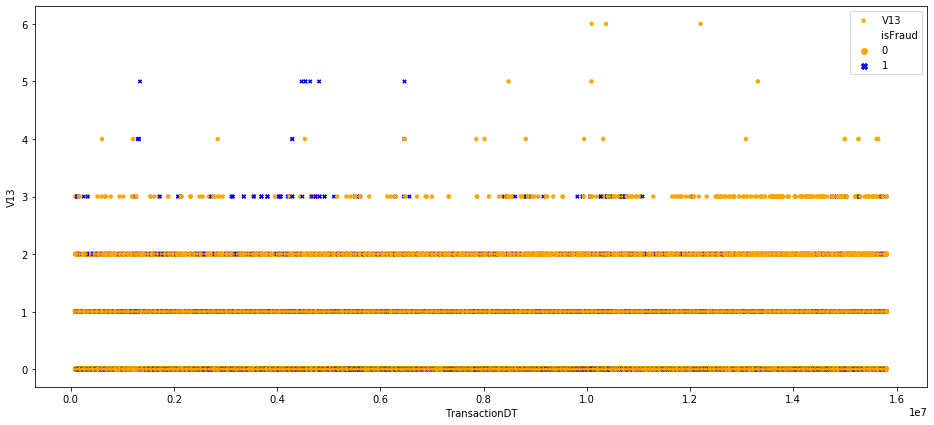

In [48]:
#TransactionDT vs V13
plt.figure(figsize=(16, 7))
#remember to drop isFraud and TransactionDT later when train model
X['isFraud']=train['isFraud']
X['TransactionDT']=train['TransactionDT']
sns.scatterplot(data=X, x="TransactionDT", y="V13",  s=20, alpha=1, edgecolor="none", label='V13', 
                hue='isFraud',style='isFraud',palette=['orange','blue']);

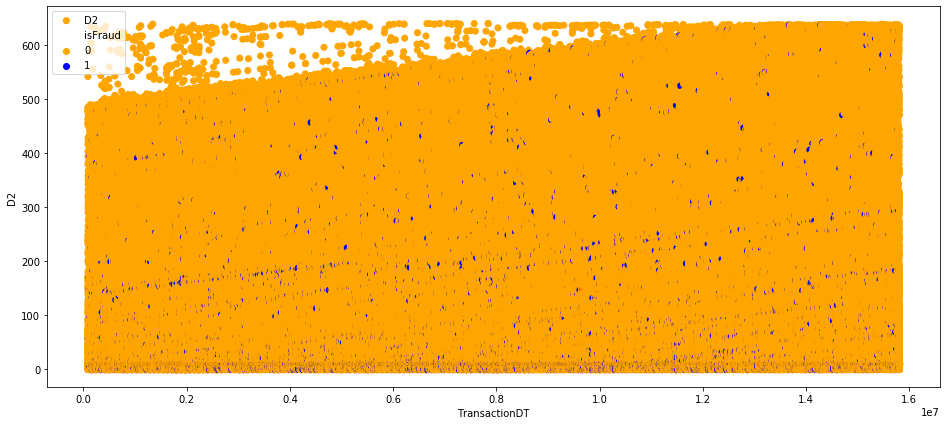

In [355]:
#TransactionDT vs D2
plt.figure(figsize=(16, 7))
#remember to drop isFraud and TransactionDT later when train model
X['isFraud']=train['isFraud']
X['TransactionDT']=train['TransactionDT']
sns.scatterplot(data=X, x="TransactionDT", y="D2",  s=50, alpha=1, edgecolor="none", label='D2', 
                hue='isFraud',palette=['orange','blue']);

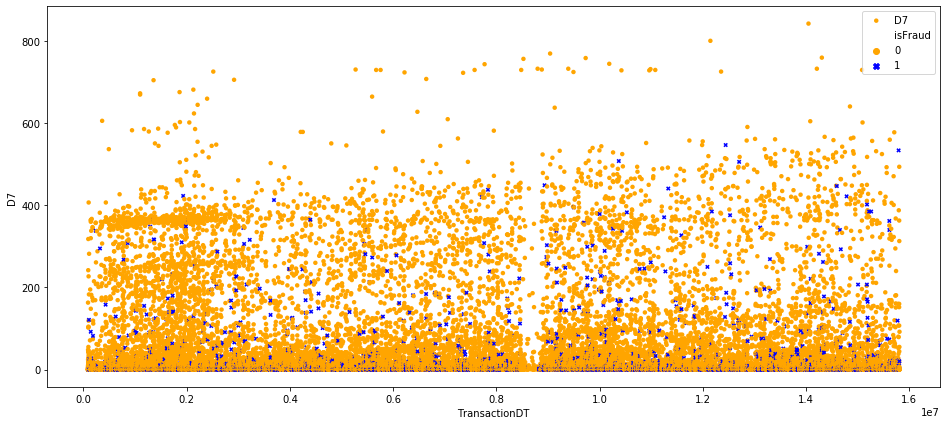

In [340]:
#TransactionDT vs D7
plt.figure(figsize=(16, 7))
#remember to drop isFraud and TransactionDT later when train model
X['isFraud']=train['isFraud']
X['TransactionDT']=train['TransactionDT']
sns.scatterplot(data=X, x="TransactionDT", y="D7",  s=20, alpha=1, edgecolor="none", label='D7', 
                hue='isFraud',palette=['orange','blue']);

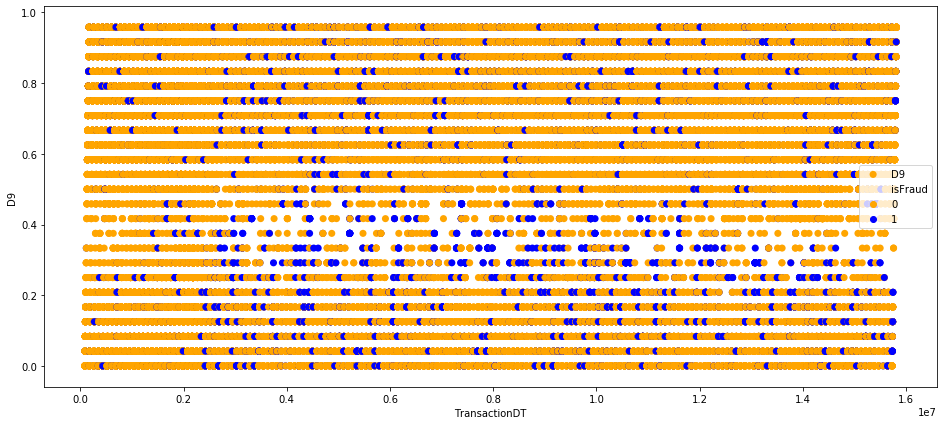

In [357]:
#TransactionDT vs D9
plt.figure(figsize=(16, 7))
#remember to drop isFraud and TransactionDT later when train model
X['isFraud']=train['isFraud']
X['TransactionDT']=train['TransactionDT']
sns.scatterplot(data=X, x="TransactionDT", y="D9",  s=50, alpha=1, edgecolor="none", label='D9', 
                hue='isFraud',palette=['orange','blue']);

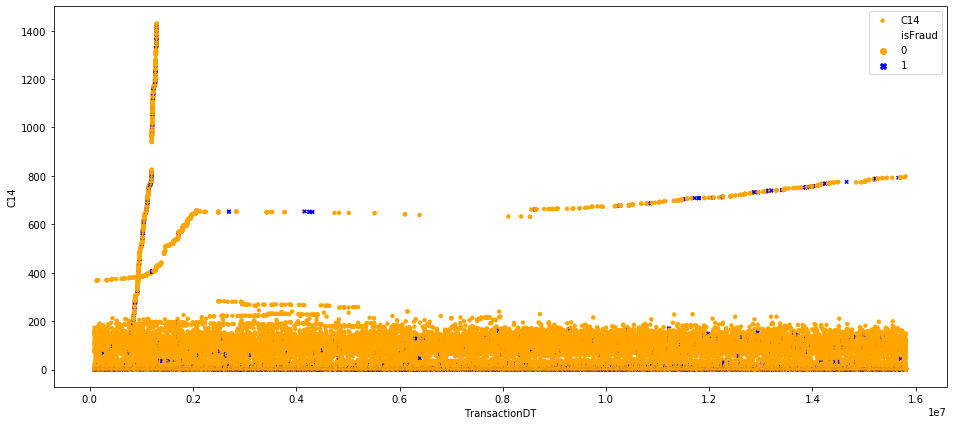

In [341]:
#TransactionDT vs C14
plt.figure(figsize=(16, 7))
#remember to drop isFraud and TransactionDT later when train model
X['isFraud']=train['isFraud']
X['TransactionDT']=train['TransactionDT']
sns.scatterplot(data=X, x="TransactionDT", y="C14",  s=20, alpha=1, edgecolor="none", label='C14', 
                hue='isFraud',palette=['orange','blue']);

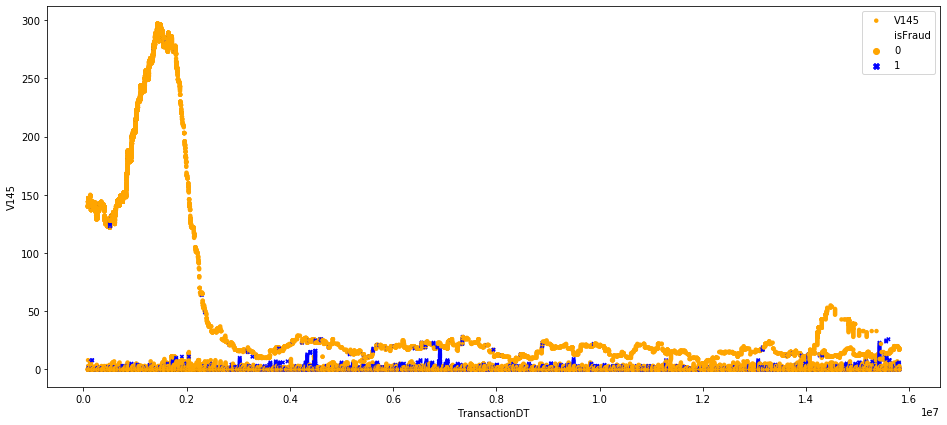

In [316]:
#TransactionDT vs V145
plt.figure(figsize=(16, 7))
#remember to drop isFraud and TransactionDT later when train model
X['isFraud']=train['isFraud']
X['TransactionDT']=train['TransactionDT']
sns.scatterplot(data=X, x="TransactionDT", y="V145",  s=20, alpha=1, edgecolor="none", label='V145', 
                hue='isFraud',palette=['orange','blue']);

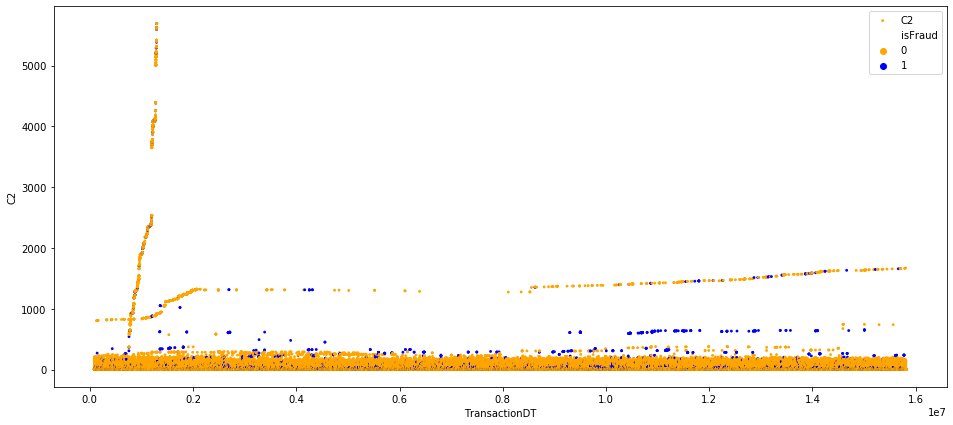

In [54]:
#findings in C2 and TransactionDT interaction:
sns.__version__
plt.figure(figsize=(16, 7))
sns.scatterplot(data=train, x="TransactionDT", y="C2",  s=8, alpha=1, edgecolor="none", label='C2',palette=['orange','blue'], hue='isFraud');

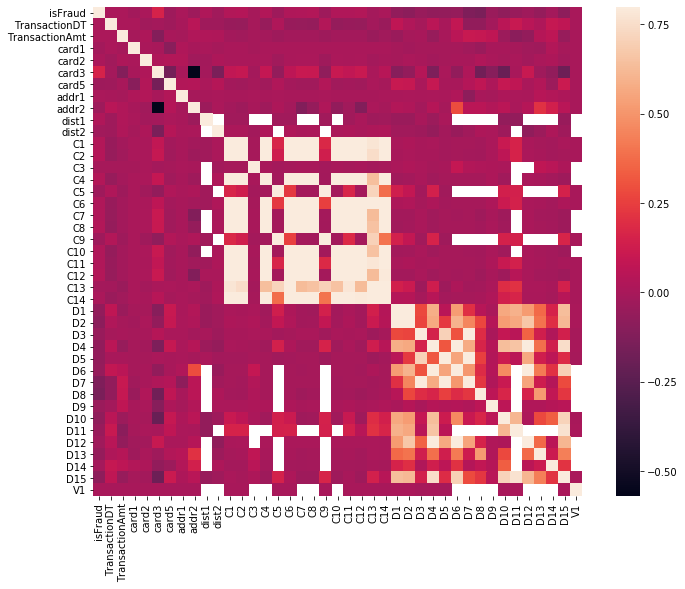

In [52]:
#corr heatmap for subset of all features
train_sub1=train[['isFraud','TransactionDT','TransactionAmt','ProductCD','card1','card2','card3',
                  'card4','card5','card6','addr1','addr2','dist1','dist2','P_emaildomain','R_emaildomain',
                  'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','D1','D2','D3','D4',
                  'D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15','M1','M2','M3','M4','M5','M6','M7',
                  'M8','M9','V1','DeviceType','DeviceInfo']]
train_sub1.reset_index(drop=False)
corrmat = train_sub1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [53]:
corrmat[:10]

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1
isFraud,1.000000,0.013103,0.011320,-0.013640,0.003388,0.154151,-0.033580,0.005596,-0.030387,0.021522,...,-0.127199,-0.142636,-0.044253,-0.072002,-0.045094,-0.028864,-0.059430,-0.008663,-0.077519,0.001045
TransactionDT,0.013103,1.000000,0.011920,0.010625,-0.019202,-0.011222,-0.024132,-0.000051,0.051972,-0.027295,...,-0.070221,-0.068752,-0.013735,0.058409,0.101266,0.053108,0.024405,0.097509,0.072791,0.001360
TransactionAmt,0.011320,0.011920,1.000000,-0.005725,0.016136,-0.109785,0.003061,-0.007421,0.028312,0.026146,...,0.099719,0.096806,0.073852,-0.038982,-0.088448,-0.065834,0.041298,0.072110,-0.054735,0.000977
card1,-0.013640,0.010625,-0.005725,1.000000,0.004960,0.002965,-0.093633,0.020369,-0.000060,0.005152,...,-0.022303,-0.040851,-0.000275,-0.000844,-0.005144,-0.020610,-0.028603,0.034955,-0.004846,0.000316
card2,0.003388,-0.019202,0.016136,0.004960,1.000000,0.023816,0.030486,0.030356,-0.022383,-0.013374,...,0.002938,0.028781,0.003446,-0.006310,0.006366,-0.013525,0.003412,0.016965,-0.014503,-0.000829
card3,0.154151,-0.011222,-0.109785,0.002965,0.023816,1.000000,-0.158383,0.001090,-0.569108,-0.012468,...,0.020721,-0.171774,-0.102086,-0.202669,0.001533,0.103120,-0.026586,-0.067191,-0.186742,-0.000065
card5,-0.033580,-0.024132,0.003061,-0.093633,0.030486,-0.158383,1.000000,0.035017,0.035726,0.008675,...,0.040080,0.075558,0.015995,0.095575,0.073589,0.007872,0.030536,-0.034712,0.110301,-0.001866
addr1,0.005596,-0.000051,-0.007421,0.020369,0.030356,0.001090,0.035017,1.000000,-0.002765,-0.001212,...,-0.079024,0.001813,-0.002913,0.013914,0.010273,0.008196,0.050886,0.032099,0.014228,-0.001638
addr2,-0.030387,0.051972,0.028312,-0.000060,-0.022383,-0.569108,0.035726,-0.002765,1.000000,-0.038691,...,0.060673,0.057475,0.032151,0.059692,0.005789,0.042501,0.208817,0.142099,0.056424,-0.000061
dist1,0.021522,-0.027295,0.026146,0.005152,-0.013374,-0.012468,0.008675,-0.001212,-0.038691,1.000000,...,NaN,NaN,NaN,-0.064056,-0.064223,NaN,NaN,NaN,-0.045665,NaN


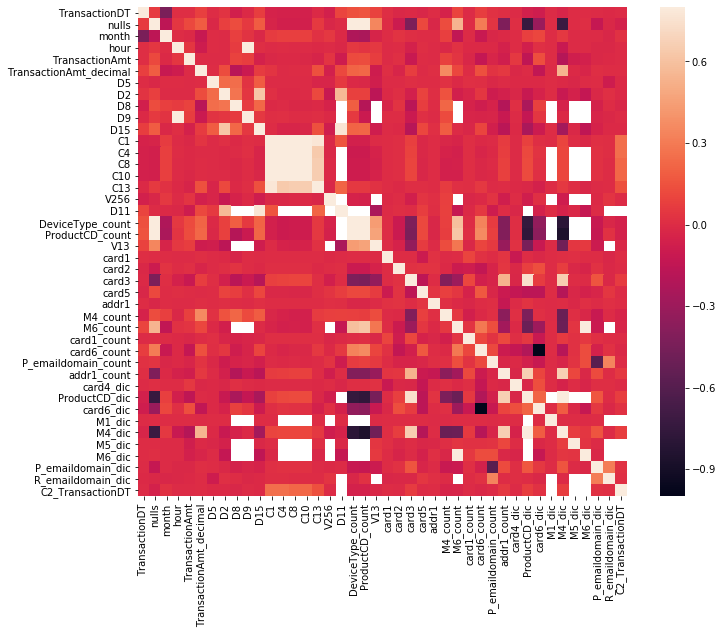

In [46]:
#heatmap with some engineered features-see data processing
train_sub1=X_for_heatmap[['TransactionDT', 'nulls', 'month', 'hour', 'TransactionAmt',
       'TransactionAmt_decimal', 'D5', 'D2', 'D8', 'D9',  'D15', 'C1',
       'C4', 'C8', 'C10', 'C13','V256', 'D11','DeviceType_count', 'ProductCD_count','V13', 'card1', 'card2', 'card3',
       'card5', 'card6','addr1','P_emaildomain','R_emaildomain', 'M4_count', 'M6_count',
       'card1_count', 'card6_count', 'ProductCD','P_emaildomain_count',
       'addr1_count', 'card4_dic', 'ProductCD_dic', 'card6_dic', 'M1_dic',
       'M4_dic', 'M5_dic', 'M6_dic', 'P_emaildomain_dic', 'R_emaildomain_dic',
       'C2_TransactionDT','M4','M6','DeviceType','DeviceInfo']]
corrmat = train_sub1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

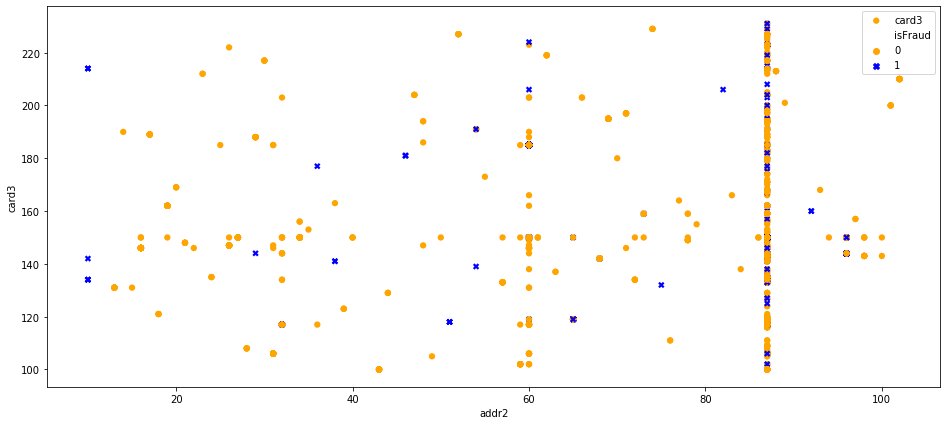

In [226]:
#card3 vs addr2
plt.figure(figsize=(16, 7))
#remember to drop isFraud later when train model
X['isFraud']=train['isFraud']
sns.scatterplot(data=X, x="addr2", y="card3", s=40, alpha=1, edgecolor="none", label='card3',palette=['orange','blue'],
                hue='isFraud',style='isFraud');

In [55]:
train['addr2'].value_counts().nlargest(50)

87.0     520481
60.0       3084
96.0        638
32.0         91
65.0         82
16.0         55
31.0         47
19.0         33
26.0         25
27.0         20
59.0         17
69.0         17
34.0         16
43.0         12
98.0         11
29.0         11
102.0        11
68.0         10
57.0         10
78.0          8
10.0          8
17.0          7
71.0          7
13.0          7
54.0          6
72.0          6
88.0          5
52.0          5
73.0          5
21.0          5
28.0          4
30.0          4
62.0          4
101.0         4
48.0          4
47.0          4
51.0          4
61.0          3
18.0          3
46.0          3
40.0          3
44.0          3
39.0          3
38.0          3
24.0          3
20.0          3
74.0          3
92.0          2
36.0          2
23.0          2
Name: addr2, dtype: int64

In [57]:
data=train.iloc[:]
data['isFraud']=y.iloc[:]
for feature in ['id_30','id_06']:
        # Count encoded separately for train and test,
    data[feature + '_count'] = data[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

data.groupby('id_06_count')['isFraud'].mean()

id_06_count
5         0.000000
6         0.000000
7         0.000000
8         0.000000
10        0.263158
11        0.000000
12        0.100000
13        0.000000
14        0.000000
15        0.000000
18        0.000000
20        0.000000
21        0.029412
23        0.021739
24        0.000000
27        0.041667
31        0.000000
33        0.000000
34        0.000000
41        0.000000
42        0.000000
43        0.000000
45        0.090909
48        0.000000
51        0.015385
55        0.040000
67        0.000000
72        0.000000
77        0.024390
78        0.000000
            ...   
1089      0.128906
1098      0.144654
1216      0.022887
1297      0.101911
1335      0.109063
1341      0.096012
1355      0.097451
1413      0.112094
1436      0.160689
1446      0.114074
1462      0.126214
1597      0.116580
1643      0.113001
1672      0.127811
1733      0.136531
1802      0.104167
2292      0.155272
2547      0.081441
3102      0.074329
3509      0.124908
3969      0.105316


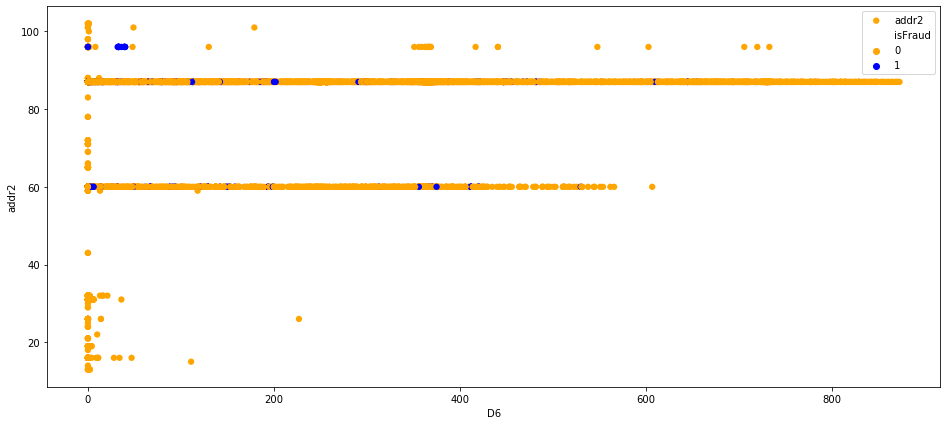

In [59]:
#D6 vs addr2
plt.figure(figsize=(16, 7))
#data['isFraud']=train['isFraud']
sns.scatterplot(data=data, x="D6", y="addr2",  s=40, alpha=1, edgecolor="none", label='addr2', hue='isFraud',palette=['orange','blue']);

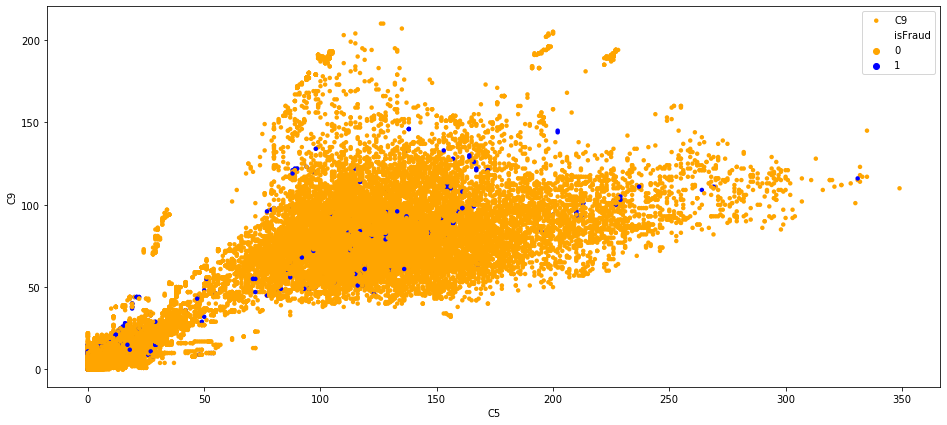

In [60]:
#C5 vs C9
plt.figure(figsize=(16, 7))
#remember to drop isFraud later when train model
sns.scatterplot(data=data, x="C5", y="C9",  s=20, alpha=1, edgecolor="none", label='C9', hue='isFraud',palette=['orange','blue']);

In [61]:
train.groupby('V13')['isFraud'].mean()

V13
0.0    0.045780
1.0    0.020890
2.0    0.075872
3.0    0.261456
4.0    0.269231
5.0    0.700000
6.0    0.000000
Name: isFraud, dtype: float64

In [62]:
train.groupby('V13')['isFraud'].count()

V13
0.0    216752
1.0    287644
2.0      9661
3.0       371
4.0        26
5.0        10
6.0         3
Name: isFraud, dtype: int64

In [66]:
train.groupby('ProductCD').count()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card4,card5,card6,...,id_38,DeviceType,DeviceInfo,TransactionDT1,month,day,dayofweek,hour,TransactionAmt_decimal,nulls
ProductCD,,,,,,,,,,,,,,,,,,,,,
C,68519,68519,68519,68519,68519,67988,68326,68324,67896,68326,...,61016,61015,41593,68519,68519,68519,68519,68519,68519,68519
H,33024,33024,33024,33024,33024,32879,33023,33014,32864,33023,...,32146,32098,31527,33024,33024,33024,33024,33024,33024,33024
R,37699,37699,37699,37699,37699,37523,37699,37698,37307,37694,...,36537,36429,36069,37699,37699,37699,37699,37699,37699,37699
S,11628,11628,11628,11628,11628,11552,11628,11628,11597,11627,...,11286,11268,9477,11628,11628,11628,11628,11628,11628,11628
W,439670,439670,439670,439670,439670,431665,438299,438299,436617,438299,...,0,0,0,439670,439670,439670,439670,439670,439670,439670


In [ ]:
#cross risk mapping for card4 vs ProductCD:
# def func(i,j):
#     if i=='american express' and j=='C':
#         return 100
#     elif i=='american express' and j=='H':
#         return 6
#     elif i=='american express' and j=='R':
#         return 2
#     elif i=='american express' and j=='S':
#         return 6
#     elif i=='discover' and j=='H':
#         return 7
#     elif i=='discover' and j=='R':
#         return 5
#     elif i=='discover' and j=='S':
#         return 13
#     elif i=='discover' and j=='W':
#         return 8
#     elif i=='mastercard' and j=='C':
#         return 11
#     elif i=='mastercard' and j=='H':
#         return 5
#     elif i=='mastercard' and j=='R':
#         return 5
#     elif i=='mastercard' and j=='S':
#         return 5
#     elif i=='mastercard' and j=='W':
#         return 2
#     elif i=='visa' and j=='C':
#         return 12
#     elif i=='visa' and j=='H':
#         return 5
#     elif i=='visa' and j=='R':
#         return 4
#     elif i=='visa' and j=='S':
#         return 6
#     elif i=='visa' and j=='W':
#         return 2  

In [14]:
#understand missing rate for below features
#X['cross'] =  X.apply(lambda x:func(x['card4'],x['ProductCD']),axis=1)

X['D5'].isna().sum()/X.shape[0]   #0.524674027161581
X['D2'].isna().sum()/X.shape[0]   #0.4754919226470688
X['D11'].isna().sum()/X.shape[0]  #0.47293494090154775
X['D15'].isna().sum()/X.shape[0]  #0.1509008703898127
#X['V1'].isna().sum()/X.shape[0]   #0.47293494090154775
#X['V2'].isna().sum()/X.shape[0]   #0.47293494090154775
#X['V13'].isna().sum()/X.shape[0]  #0.1288193856470349
#X['V263'].isna().sum()/X.shape[0] #0.7791343516103905
X['card2'].isna().sum()/X.shape[0] #0.015126833068039422
X['card3'].isna().sum()/X.shape[0] #0.0026501168422122124
X['card4_dic'].isna().sum()/X.shape[0] #0.00267043722694483
X['M4_dic'].isna().sum()/X.shape[0] #0.47658753005723575
X['M6_dic'].isna().sum()/X.shape[0] #0.28678836319300977
X['cross'].isna().sum()/X.shape[0]   #0.00267043722694483
X['R_emaildomain_dic'].isna().sum()/X.shape[0] #0.8257611677447759

KeyError: 'V1'

In [64]:
train[train['D15'].isna()==True]['isFraud'].mean()

0.04798402028884675

[301873, 268004, 7870, 12793]

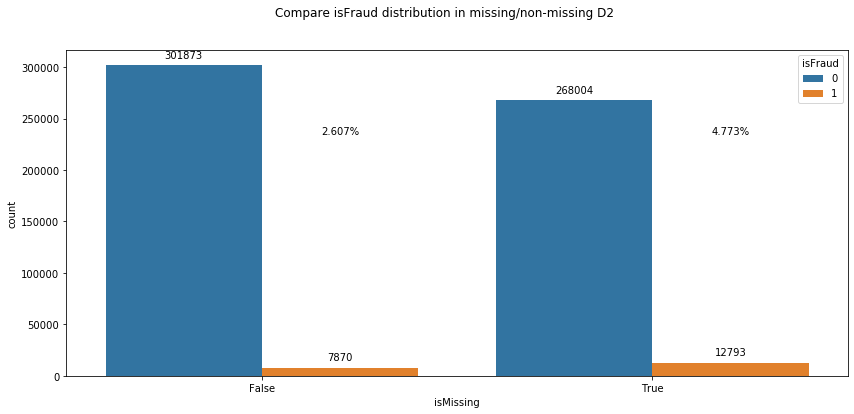

In [68]:
#Strategy: plot to decide how to fill missing data:
#for example if missing value in a column correspond to higher fraud rate, then use the level with higher risk to fill missing, 
#or simply use 'other'.
import matplotlib.pyplot as plt
def plt_compare_missing(var):
    plt.figure(figsize=(14, 6))
#    plt.subplot(1,2,1)
    data= pd.DataFrame()
    data['isMissing']=train[var].isna()
    data['isFraud']=train['isFraud']
    suptitle("Compare isFraud distribution in missing/non-missing "+var)
    splot=sns.countplot(x='isMissing',hue='isFraud', data=data)
    res=[]
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2.,
            p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        res.append(p.get_height())
    splot.annotate(format(res[2]*100/res[0], '.3f')+'%', (p.get_x() - p.get_width()*2 ,
        p.get_height()*10+100000), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    splot.annotate(format(res[3]*100/res[1], '.3f')+'%', (p.get_x() + p.get_width()/2 ,
        p.get_height()*10+100000), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    return res
    
    
#     plt.subplot(1,2,2)
#     data = pd.concat([train['isFraud'],train[var]], axis=1)
#     suptitle("Compare isFraud distribution in levels of "+var)
#     splot=sns.countplot(x=var,hue='isFraud', data=data)
    
plt_compare_missing('D2')

In [70]:
a = train.groupby('D2')['isFraud'].mean()
a.nlargest(15)

D2
1.0      0.114968
2.0      0.099461
3.0      0.088659
6.0      0.067471
5.0      0.066285
4.0      0.063397
0.0      0.061822
24.0     0.051336
545.0    0.047826
9.0      0.047271
10.0     0.046951
11.0     0.045768
25.0     0.044077
159.0    0.043779
8.0      0.042422
Name: isFraud, dtype: float64

[67099, 502778, 7827, 12836]

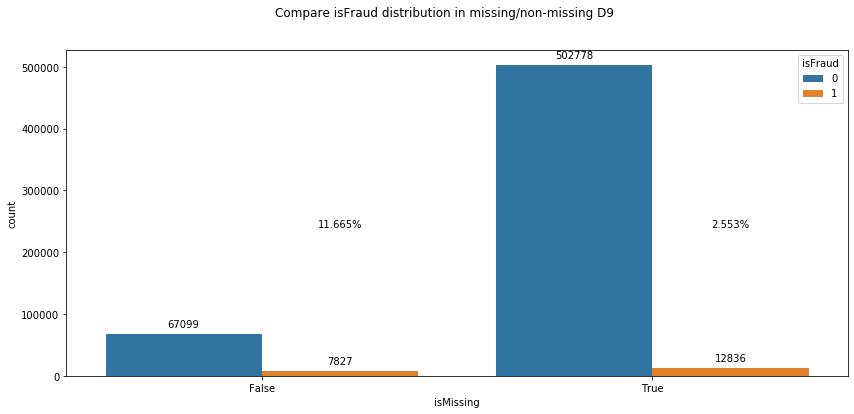

In [71]:
plt_compare_missing('D9')

In [137]:
a = train.groupby('D9')['isFraud'].mean()
a.nlargest(50)

D9
0.291666    0.310709
0.375000    0.306502
0.333333    0.271318
0.250000    0.233365
0.416666    0.183168
0.208333    0.171458
0.458333    0.156889
0.166666    0.151113
0.083333    0.123725
0.958333    0.120834
0.125000    0.112757
0.000000    0.108353
0.041666    0.107946
0.875000    0.106444
0.916666    0.106306
0.791666    0.095768
0.833333    0.095202
0.750000    0.091898
0.500000    0.086072
0.708333    0.080670
0.666666    0.074965
0.625000    0.059817
0.583333    0.058178
0.541666    0.047701
Name: isFraud, dtype: float64

[305147, 264730, 6106, 14557]

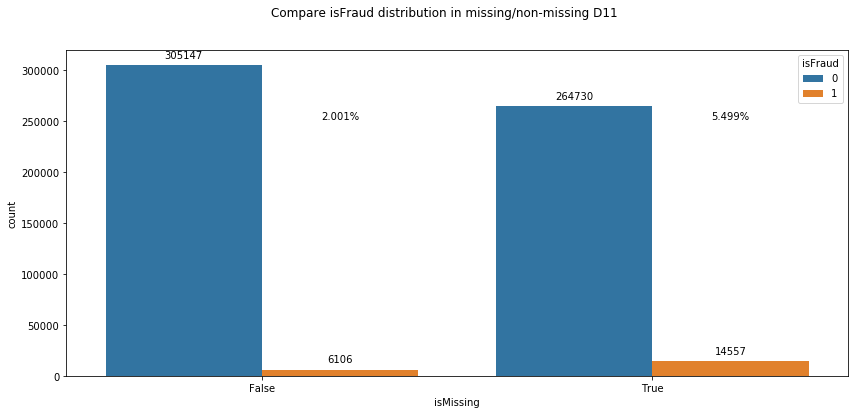

In [72]:
plt_compare_missing('D11')

In [115]:
a = train.groupby('D11')['isFraud'].mean()
a.nlargest(20)

D11
1.0      0.087836
2.0      0.083168
3.0      0.077954
4.0      0.077295
104.0    0.069971
6.0      0.062500
655.0    0.058824
11.0     0.055391
10.0     0.054359
347.0    0.052863
5.0      0.052669
176.0    0.047431
25.0     0.047354
52.0     0.047297
9.0      0.046070
111.0    0.043077
7.0      0.042709
525.0    0.041475
12.0     0.039877
19.0     0.039735
Name: isFraud, dtype: float64

[485040, 84837, 16387, 4276]

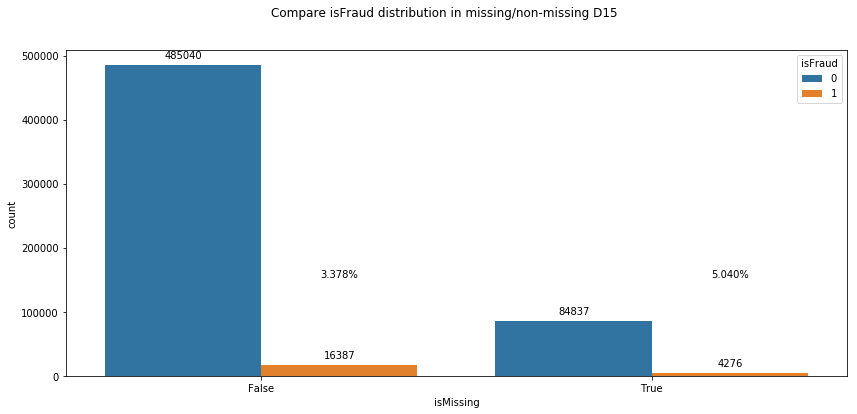

In [22]:
plt_compare_missing('D15')

In [78]:
a = train.groupby('D15')['isFraud'].mean()
a.nlargest(30)

D15
835.0    0.666667
687.0    0.200000
699.0    0.200000
667.0    0.166667
1.0      0.120620
2.0      0.119209
269.0    0.101983
3.0      0.092078
356.0    0.090426
5.0      0.076199
25.0     0.076077
4.0      0.071512
9.0      0.063977
666.0    0.062500
8.0      0.060314
6.0      0.060193
10.0     0.059443
137.0    0.054502
47.0     0.054334
150.0    0.054326
198.0    0.053846
7.0      0.051998
23.0     0.051915
11.0     0.051780
22.0     0.051302
376.0    0.049180
18.0     0.048348
104.0    0.047863
97.0     0.047128
291.0    0.047022
Name: isFraud, dtype: float64

[568341, 1536, 20622, 41]

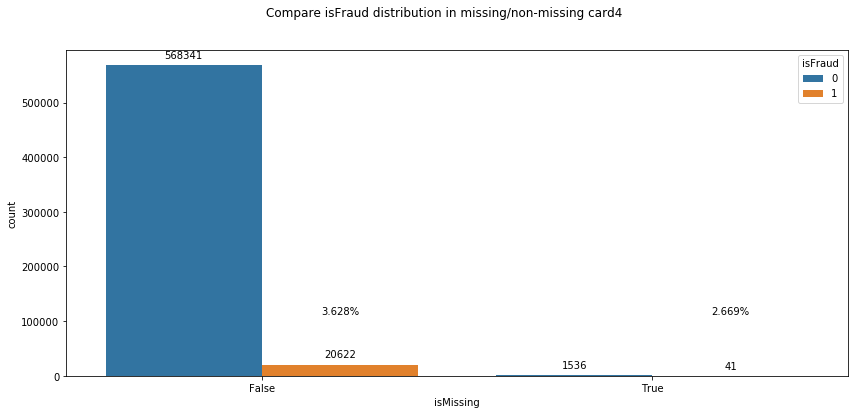

In [79]:
plt_compare_missing('card4')
#X['card4_dic'].isna()

In [80]:
a = train.groupby('card4')['isFraud'].mean()
a

card4
american express    0.028698
discover            0.077282
mastercard          0.034331
visa                0.034756
Name: isFraud, dtype: float64

[511912, 57965, 12922, 7741]

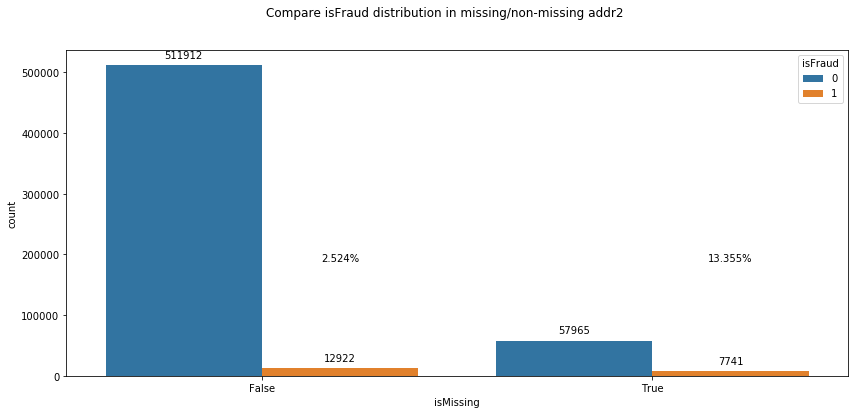

In [81]:
plt_compare_missing('addr2')

In [84]:
a = train.groupby('addr2')['isFraud'].mean()
a.nlargest(15)

addr2
10.0    1.000000
46.0    1.000000
51.0    1.000000
75.0    1.000000
82.0    1.000000
92.0    1.000000
38.0    0.666667
65.0    0.536585
36.0    0.500000
54.0    0.333333
73.0    0.200000
96.0    0.139498
68.0    0.100000
29.0    0.090909
60.0    0.090467
Name: isFraud, dtype: float64

In [86]:
a = train.groupby('addr2')['isFraud'].mean()
a = train.groupby('addr2')['isFraud'].count()
a.nlargest(20)
#a.sort_values(ascending=False).iloc[0:50]

addr2
87.0     520481
60.0       3084
96.0        638
32.0         91
65.0         82
16.0         55
31.0         47
19.0         33
26.0         25
27.0         20
59.0         17
69.0         17
34.0         16
43.0         12
29.0         11
98.0         11
102.0        11
57.0         10
68.0         10
10.0          8
Name: isFraud, dtype: int64

In [87]:
a = train.groupby('ProductCD')['isFraud'].mean()
a

ProductCD
C    0.116873
H    0.047662
R    0.037826
S    0.058996
W    0.020399
Name: isFraud, dtype: float64

In [88]:
a = train.groupby('card6')['isFraud'].mean()
a

card6
charge card        0.000000
credit             0.066785
debit              0.024263
debit or credit    0.000000
Name: isFraud, dtype: float64

[561367, 8510, 20240, 423]

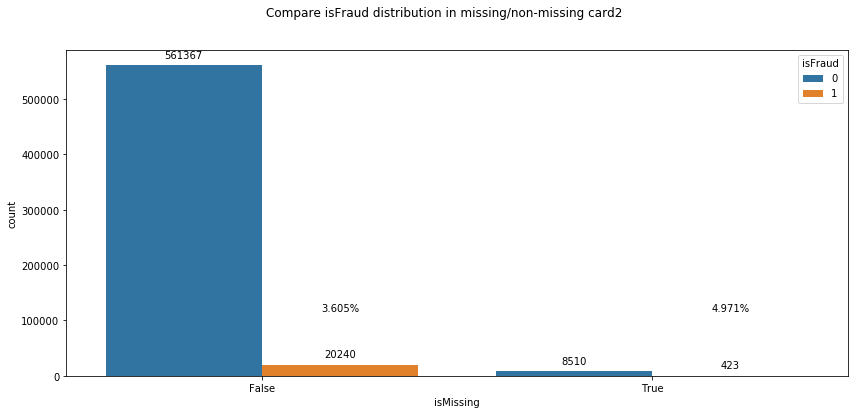

In [89]:
plt_compare_missing('card2')

In [90]:
a = train.groupby('card2')['isFraud'].mean()
a.nlargest(80)

card2
289.0    0.406780
405.0    0.403509
319.0    0.390000
176.0    0.360624
482.0    0.327381
407.0    0.303571
311.0    0.280277
104.0    0.248011
324.0    0.241692
177.0    0.241169
142.0    0.240356
130.0    0.239257
141.0    0.236559
585.0    0.210127
357.0    0.208333
459.0    0.199409
211.0    0.198020
156.0    0.196078
341.0    0.192982
296.0    0.191971
266.0    0.191514
500.0    0.180575
529.0    0.180371
238.0    0.178344
463.0    0.178082
279.0    0.176991
440.0    0.164134
273.0    0.153846
246.0    0.152672
403.0    0.144444
           ...   
536.0    0.075658
340.0    0.071429
187.0    0.070588
283.0    0.070423
119.0    0.069264
537.0    0.068441
404.0    0.065118
453.0    0.065075
308.0    0.064982
439.0    0.062893
216.0    0.061356
594.0    0.061321
398.0    0.057143
573.0    0.056338
181.0    0.055589
231.0    0.055363
544.0    0.054795
387.0    0.053973
384.0    0.053691
299.0    0.053659
547.0    0.053498
443.0    0.053097
488.0    0.052632
228.0    0.052023
565.

[568351, 1526, 20624, 39]

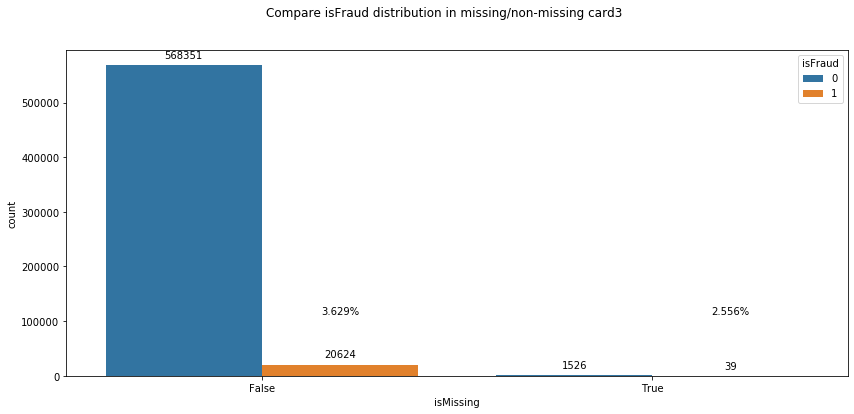

In [91]:
plt_compare_missing('card3')

In [93]:
a = train.groupby('card3')['isFraud'].mean()
a.nlargest(45)

card3
125.0    1.000000
132.0    1.000000
139.0    1.000000
160.0    1.000000
175.0    1.000000
181.0    1.000000
206.0    1.000000
224.0    1.000000
208.0    0.500000
191.0    0.388889
155.0    0.333333
223.0    0.254545
167.0    0.250000
118.0    0.235294
129.0    0.222222
157.0    0.200000
198.0    0.193548
182.0    0.179487
231.0    0.166667
127.0    0.142857
185.0    0.130657
142.0    0.125000
183.0    0.111111
219.0    0.111111
119.0    0.093333
168.0    0.090909
214.0    0.090909
144.0    0.089457
133.0    0.080000
180.0    0.076923
134.0    0.066265
141.0    0.061224
177.0    0.060606
121.0    0.050505
135.0    0.050000
100.0    0.049505
126.0    0.043478
137.0    0.042254
188.0    0.034286
143.0    0.031146
210.0    0.028846
138.0    0.028571
111.0    0.025641
150.0    0.024568
159.0    0.024390
Name: isFraud, dtype: float64

[293660, 276217, 15436, 5227]

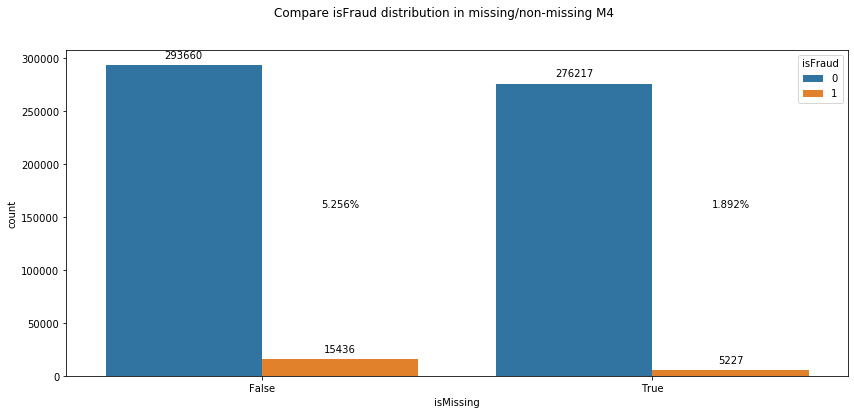

In [94]:
plt_compare_missing('M4')

In [95]:
a = train.groupby('M4')['isFraud'].mean()
a.nlargest(5)

M4
M2    0.113739
M0    0.036649
M1    0.027051
Name: isFraud, dtype: float64

[412488, 157389, 8692, 11971]

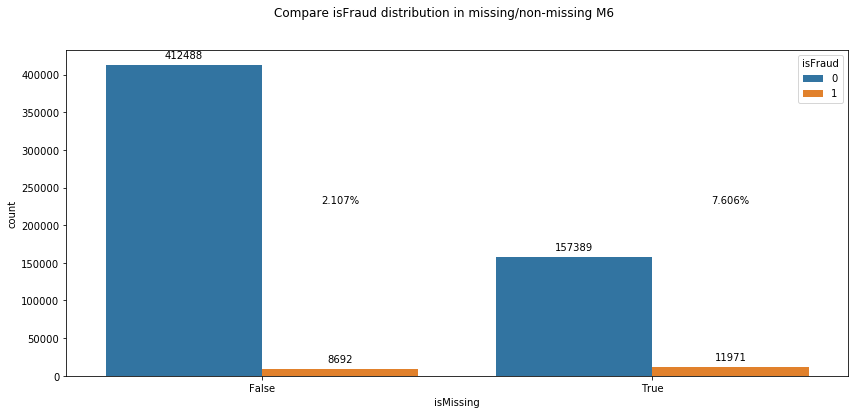

In [96]:
plt_compare_missing('M6')

In [98]:
a = train.groupby('M6')['isFraud'].mean()
a

M6
F    0.023686
T    0.017044
Name: isFraud, dtype: float64

[239471, 330406, 4817, 15846]

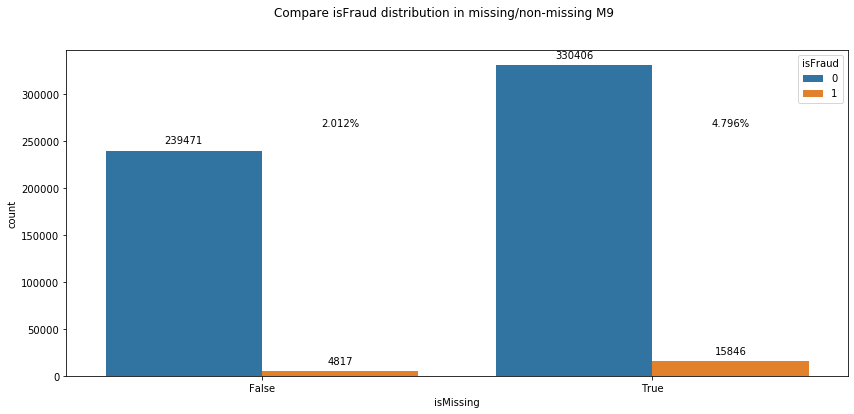

In [99]:
plt_compare_missing('M9')

In [100]:
a = train.groupby('M9')['isFraud'].mean()
a

M9
F    0.030001
T    0.017787
Name: isFraud, dtype: float64

[407004, 162873, 14567, 6096]

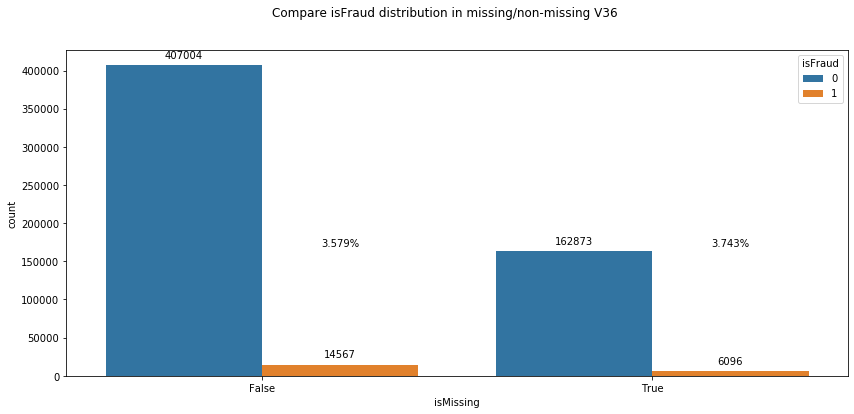

In [101]:
plt_compare_missing('V36')

In [102]:
a = train.groupby('V36')['isFraud'].mean()
#a = train.groupby('V36')['isFraud'].count()
a

V36
0.0    0.051116
1.0    0.020179
2.0    0.049236
3.0    0.101010
4.0    0.200000
5.0    0.000000
Name: isFraud, dtype: float64

[497691, 72186, 16776, 3887]

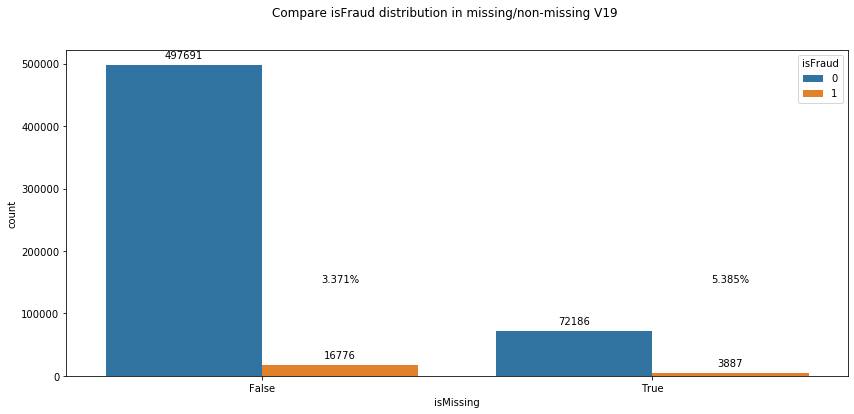

In [105]:
plt_compare_missing('V19')

In [106]:
a = train.groupby('V19')['isFraud'].mean()
#a.nlargest(50)
#a = train.groupby('V2')['isFraud'].count()
a

V19
0.0    0.024757
1.0    0.033705
2.0    0.080122
3.0    0.152299
4.0    0.103448
5.0    0.333333
6.0    0.000000
7.0    0.000000
Name: isFraud, dtype: float64

[132915, 436962, 11318, 9345]

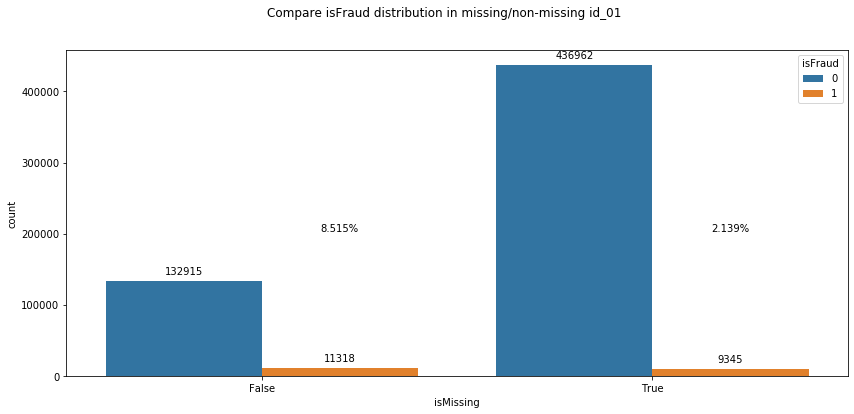

In [107]:
plt_compare_missing('id_01')

In [110]:
a = train.groupby('id_01')['isFraud'].count()
a.nlargest(20)

id_01
-5.0      82170
 0.0      19555
-10.0     11257
-20.0     11211
-15.0      5674
-25.0      4623
-45.0      2143
-35.0      1622
-40.0      1385
-100.0     1012
-50.0       709
-30.0       682
-95.0       428
-60.0       410
-55.0       320
-80.0       220
-90.0       214
-70.0        97
-65.0        93
-85.0        87
Name: isFraud, dtype: int64

In [111]:
a = train.groupby('id_01')['isFraud'].mean()
a.nlargest(40)
#a.sort_values(ascending=False)

id_01
-72.0     1.000000
-32.0     1.000000
-18.0     0.695652
-31.0     0.555556
-19.0     0.555556
-88.0     0.500000
-11.0     0.333333
-50.0     0.317348
-100.0    0.263834
-9.0      0.250000
-35.0     0.227497
-30.0     0.218475
-95.0     0.214953
-37.0     0.200000
-23.0     0.200000
-70.0     0.195876
-90.0     0.177570
-16.0     0.153846
-55.0     0.150000
-65.0     0.139785
-60.0     0.136585
-12.0     0.133333
-20.0     0.125413
-10.0     0.119392
-85.0     0.114943
-15.0     0.114381
-45.0     0.112926
-17.0     0.111111
-40.0     0.105415
-25.0     0.096474
-75.0     0.096386
-21.0     0.083333
-6.0      0.066667
-5.0      0.057965
-80.0     0.050000
 0.0      0.049757
-99.0     0.000000
-96.0     0.000000
-94.0     0.000000
-93.0     0.000000
Name: isFraud, dtype: float64

[128230, 441647, 11031, 9632]

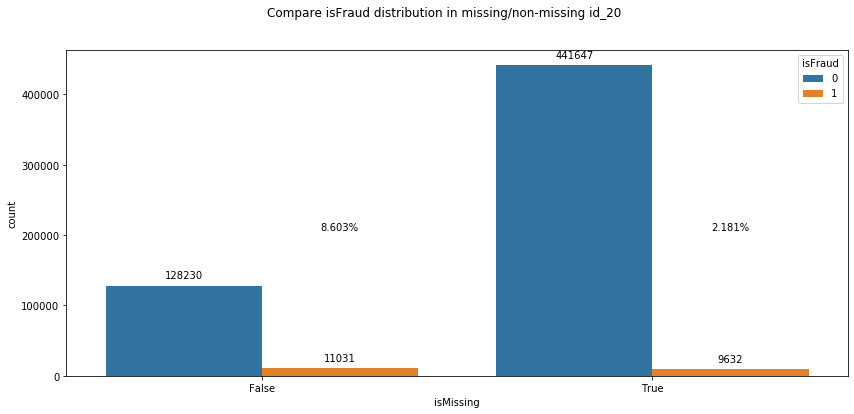

In [112]:
plt_compare_missing('id_20')

In [116]:
a = train.groupby('id_20')['isFraud'].mean()
a.sort_values(ascending=False).iloc[80:120]

id_20
181.0    0.041551
633.0    0.039604
501.0    0.039326
277.0    0.038903
446.0    0.037037
575.0    0.036697
460.0    0.035714
222.0    0.035246
204.0    0.035088
100.0    0.034314
489.0    0.033333
214.0    0.033192
500.0    0.029601
456.0    0.029412
411.0    0.025806
144.0    0.025185
280.0    0.024823
146.0    0.024482
299.0    0.024390
266.0    0.021997
484.0    0.019892
514.0    0.019512
472.0    0.019274
177.0    0.016973
404.0    0.016878
424.0    0.016393
225.0    0.015531
107.0    0.014870
368.0    0.014865
474.0    0.014706
391.0    0.013230
223.0    0.012821
278.0    0.011820
142.0    0.011111
439.0    0.009259
611.0    0.008591
254.0    0.008333
186.0    0.007500
178.0    0.007018
215.0    0.004464
Name: isFraud, dtype: float64

In [119]:
#check M4_dic risk mapping
M4_dic={'M0':4,'M1':3,'M2':13}
X['M4_dic']=train['M4'].map(M4_dic)
X['isFraud']=y
a = X.groupby('M4_dic')['isFraud'].mean()
a

M4_dic
3.0     0.027051
4.0     0.036649
13.0    0.113739
Name: isFraud, dtype: float64

In [120]:
X[X['M4_dic'].isna()==True]['isFraud'].mean()
#data=pd.concat([X,y], axis=1)
#data[data['cross'].isna()==True]['isFraud'].mean()

0.018572078282002816

In [121]:
#create is_missing features?
X[X['M4_dic'].isna()==False]['isFraud'].mean()

0.049939177472371046

In [211]:
#check cross risk mapping
c = train.groupby(['card4','ProductCD'])['isFraud'].mean()
c

#check cross risk mapping M4 vs M6
d = train.groupby(['M4','M6'])['isFraud'].mean()
d

e = X.groupby(['DeviceType_count','ProductCD_count'])['isFraud'].mean()
e

card4             ProductCD
american express  C            1.000000
                  H            0.058110
                  R            0.018084
                  S            0.056270
discover          H            0.074627
                  R            0.051423
                  S            0.132759
                  W            0.076730
mastercard        C            0.112043
                  H            0.052028
                  R            0.050188
                  S            0.049480
                  W            0.017122
visa              C            0.120184
                  H            0.044702
                  R            0.038413
                  S            0.058584
                  W            0.021178
Name: isFraud, dtype: float64

In [141]:
#check M6_dic
X['isFraud']=y
a = X.groupby('M6_dic')['isFraud'].mean()
a

M6_dic
3.0    0.017044
4.0    0.023686
Name: isFraud, dtype: float64

[129599, 440278, 11211, 9452]

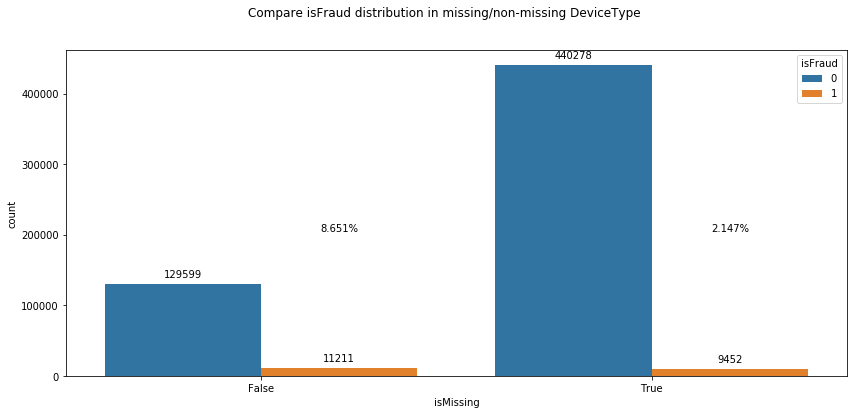

In [216]:
plt_compare_missing('DeviceType')

In [220]:
a = train.groupby('DeviceType')['isFraud'].mean()
a

DeviceType
desktop    0.065215
mobile     0.101662
Name: isFraud, dtype: float64

[110059, 459818, 8607, 12056]

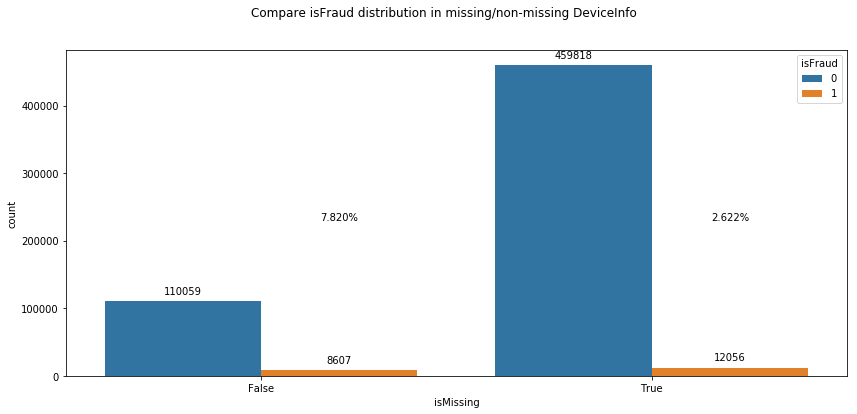

In [217]:
plt_compare_missing('DeviceInfo')

In [122]:
#Create bins for regrouping features such as DeviceInfo,P_ and (R__) emaildomain
a = train.groupby('DeviceInfo')['isFraud'].mean()
a

DeviceInfo
0PAJ5                         0.000000
0PJA2                         0.000000
0PM92                         0.500000
1016S                         0.000000
2PQ93                         0.000000
2PS64 Build/NRD90M            0.000000
2PYB2                         0.000000
2PZC5                         0.000000
4003A                         0.000000
4009F                         0.000000
4013M Build/KOT49H            0.076923
4027A Build/KOT49H            0.000000
4034E                         0.000000
4034G                         0.000000
4047A Build/NRD90M            0.000000
4047G Build/NRD90M            0.058824
47418                         0.000000
5010G Build/MRA58K            0.100000
5010S Build/MRA58K            0.000000
5011A Build/NRD90M            0.125000
5012G Build/MRA58K            0.172414
5015A Build/LMY47I            0.236842
5017A                         0.000000
5025G Build/LMY47I            0.289474
5042A                         0.000000
5044A         

In [125]:
a = train.groupby('DeviceInfo')['isFraud'].count()
a

DeviceInfo
0PAJ5                           1
0PJA2                           1
0PM92                           4
1016S                           1
2PQ93                           1
2PS64 Build/NRD90M              6
2PYB2                           4
2PZC5                           2
4003A                           1
4009F                           2
4013M Build/KOT49H             13
4027A Build/KOT49H              2
4034E                           1
4034G                           1
4047A Build/NRD90M              7
4047G Build/NRD90M             17
47418                           1
5010G Build/MRA58K             60
5010S Build/MRA58K             13
5011A Build/NRD90M             24
5012G Build/MRA58K             29
5015A Build/LMY47I             38
5017A                           2
5025G Build/LMY47I             38
5042A                           2
5044A                           1
5045I                           1
5049W Build/NRD90M              9
5051A Build/MMB29M              6
505

In [374]:
t=train[train['isFraud']==1]['DeviceInfo']
t.reset_index().groupby('DeviceInfo')['TransactionID'].count()

DeviceInfo
0PM92                                 2
4013M Build/KOT49H                    1
4047G Build/NRD90M                    1
5010G Build/MRA58K                    6
5011A Build/NRD90M                    3
5012G Build/MRA58K                    5
5015A Build/LMY47I                    9
5025G Build/LMY47I                   11
5049W Build/NRD90M                    6
5056A Build/MMB29M                    3
5085B Build/MRA58K                    2
6045I Build/LRX22G                    2
8062 Build/MRA58K                     1
9003A Build/MRA58K                    3
A466BG                                3
A5002                                 1
A574BL Build/NMF26F                   7
AERIAL                                1
ALCATEL                               1
ALE-L23 Build/HuaweiALE-L23          29
ALP-L09 Build/HUAWEIALP-L09           3
Alcatel_4060O Build/MMB29M            5
Alcatel_5044R Build/NRD90M            4
Alumini3 Build/MRA58K                 2
Android 5.1                  

In [126]:
#P_ and (R__) emaildomain
a = train.groupby('P_emaildomain')['isFraud'].count()
a

P_emaildomain
aim.com                315
anonymous.com        36998
aol.com              28289
att.net               4033
bellsouth.net         1909
cableone.net           159
centurylink.net        205
cfl.rr.com             172
charter.net            816
comcast.net           7888
cox.net               1393
earthlink.net          514
embarqmail.com         260
frontier.com           280
frontiernet.net        195
gmail                  496
gmail.com           228355
gmx.de                 149
hotmail.co.uk          112
hotmail.com          45250
hotmail.de              43
hotmail.es             305
hotmail.fr             295
icloud.com            6267
juno.com               322
live.com              3041
live.com.mx            749
live.fr                 56
mac.com                436
mail.com               559
me.com                1522
msn.com               4092
netzero.com            230
netzero.net            196
optonline.net         1011
outlook.com           5096
outlook.es    

In [127]:
a = train.groupby('P_emaildomain')['isFraud'].mean()
a

P_emaildomain
aim.com             0.126984
anonymous.com       0.023217
aol.com             0.021811
att.net             0.007439
bellsouth.net       0.027763
cableone.net        0.018868
centurylink.net     0.000000
cfl.rr.com          0.000000
charter.net         0.030637
comcast.net         0.031187
cox.net             0.020818
earthlink.net       0.021401
embarqmail.com      0.034615
frontier.com        0.028571
frontiernet.net     0.025641
gmail               0.022177
gmail.com           0.043542
gmx.de              0.000000
hotmail.co.uk       0.000000
hotmail.com         0.052950
hotmail.de          0.000000
hotmail.es          0.065574
hotmail.fr          0.000000
icloud.com          0.031434
juno.com            0.018634
live.com            0.027622
live.com.mx         0.054740
live.fr             0.000000
mac.com             0.032110
mail.com            0.189624
me.com              0.017740
msn.com             0.021994
netzero.com         0.000000
netzero.net         0.005102


In [128]:
a = train.groupby('R_emaildomain')['isFraud'].count()
a

R_emaildomain
aim.com                36
anonymous.com       20529
aol.com              3701
att.net               430
bellsouth.net         422
cableone.net           27
centurylink.net        12
cfl.rr.com             37
charter.net           127
comcast.net          1812
cox.net               459
earthlink.net          79
embarqmail.com         68
frontier.com           52
frontiernet.net        14
gmail                  95
gmail.com           57147
gmx.de                147
hotmail.co.uk         105
hotmail.com         27509
hotmail.de             42
hotmail.es            292
hotmail.fr            293
icloud.com           1398
juno.com               53
live.com              762
live.com.mx           754
live.fr                55
mac.com               218
mail.com              122
me.com                556
msn.com               852
netzero.com            14
netzero.net             9
optonline.net         187
outlook.com          2507
outlook.es            433
prodigy.net.mx        20